# Regrid pft output to grids per variable and pft (intermediate postprocessing step) 


(c) Inne Vanderkelen - October 2023

## 1. Settings

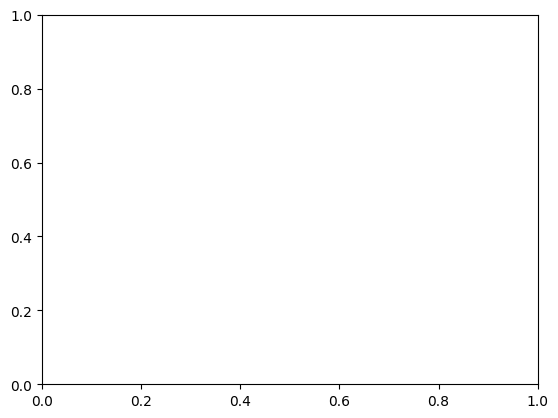

In [1]:
# laod modules 
import xarray as xr
import matplotlib.pyplot as plt
import os
import regionmask 

# import own utils module
from iv_utils_daint import *
from ctsm_py.utils import * #info on ctsm utils: https://github.com/NCAR/ctsm_python_gllery 

# do plotting settings
set_plot_param()

# ignore all runtime warnings
warnings.filterwarnings('ignore')

In [2]:
# directory settings

# set directories
outdir = '/capstor/scratch/cscs/ivanderk/' #'/project/s1207/ivanderk/scratch/' 
# Define directory where processing is done 
procdir =  outdir + 'processing_4p1000/' 

# go to processing directory 
os.chdir(procdir)

In [3]:
# case settings

# define scenario
scenario = '4p1000' #'high'

# case settings
case_ctl = 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.CTL.spunup5'
case_scen = 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.'+scenario+'.spunup5'

case   = case_ctl
block  = 'lnd' 
stream = 'h1' 

# List of variables to import from file(s) in $indir matching $pattern.
variables = ['H2OSOI',"TOTSOILLIQ","TOTSOILICE", "QINFL" , "QOVER", "QDRAI", 'EFLX_LH_TOT',  "watsat","QROOTSINK" ,"QVEGE", "QVEGT","QSOIL",
             "watfc",  "SMP",  "patches1d_itype_veg"]
# "SOILLIQ",
# discard 2004 until 2008 as spin up years
start_year, end_year = 1995, 2014 # 2028 

time_slice = slice(str(start_year)+"-01-01", str(end_year)+"-12-31")

In [4]:
# get pfts modelled - bare soil, grassland and crop pfts
pft_list = [0,12,13,14,15,16]

In [5]:
# calculate saturated fraction
def calc_and_safe_saturated_fraction(pft_list, case): 
    for pft_int in pft_list: 

        print('processing pft '+str(pft_int))

        da_h2soi = load_da_gridded_pft('H2OSOI', pft_int, case).rename('H2OSOI').rename({'ivt_str':'pft'})
        da_watsat = load_da_gridded_pft('watsat', pft_int, case)
        da_watsat = da_watsat.rename('watsat').rename({'ivt_str':'pft'}).rename({'levgrnd':'levsoi'}).isel(levsoi=range(0,20))

        da_satfrac = (da_h2soi/da_watsat).rename('satfrac').assign_attrs({'units':'-','long_name':'saturated fraction'})

        del da_watsat, da_h2soi

        ds_gridded = xr.Dataset()

        ds_gridded['satfrac_'+str(pft_int)] = da_satfrac

        ds_gridded.to_netcdf(procdir+'/postprocessing/pft_gridding/'+'satfrac'+'_'+str(pft_int)+'.'+case+'.nc')

        del ds_gridded    

## Regrid control case

In [6]:
# get pfts modelled - bare soil, grassland and crop pfts
pft_list = [15]

In [7]:
%%time

case_ctl = 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.CTL.spunup5'
variables = ['H2OSOI',  "patches1d_itype_veg"]
ds_ctl = import_case(case_ctl, myVars=variables,  myVegtypes=pft_list, timeSlice=time_slice, stream=stream, alter_lons=False)


CPU times: user 1min 8s, sys: 17.2 s, total: 1min 25s
Wall time: 1min 37s


In [8]:
%%time
grid_multiple_pfts_multiple_vars(ds_ctl, variables,  pft_list, case_ctl)

processing variable H2OSOI
processing pft 15
/capstor/scratch/cscs/ivanderk/processing_4p1000//postprocessing/pft_gridding/H2OSOI_15.IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.CTL.spunup5.nc
processing variable patches1d_itype_veg
processing pft 15
/capstor/scratch/cscs/ivanderk/processing_4p1000//postprocessing/pft_gridding/patches1d_itype_veg_15.IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.CTL.spunup5.nc
CPU times: user 18.3 s, sys: 22.5 s, total: 40.8 s
Wall time: 1min 7s


In [10]:
%%time

# calculate and safe saturated fraction
calc_and_safe_saturated_fraction(pft_list, case_ctl)

processing pft 15


FileNotFoundError: [Errno 2] No such file or directory: '/project/s1207/ivanderk/scratch/processing_4p1000/postprocessing/pft_gridding/H2OSOI_15.IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.CTL.spunup5.nc'

In [11]:
#variables = ['H2OSOI', 'SMP', 'QROOTSINK', "patches1d_itype_veg"]
# define scenario
scenario = 'high' #'high'
variables = ['H2OSOI',"patches1d_itype_veg"]

# case settings
case_scen = 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.'+scenario+'.spunup5'

In [12]:
ds_scen = import_case(case_scen, myVars=variables,  myVegtypes=pft_list, timeSlice=time_slice, stream=stream, alter_lons=False)

In [13]:
%%time
grid_multiple_pfts_multiple_vars(ds_scen, variables,  pft_list, case_scen)

processing variable H2OSOI
processing pft 15
/capstor/scratch/cscs/ivanderk/processing_4p1000//postprocessing/pft_gridding/H2OSOI_15.IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.high.spunup5.nc
processing variable patches1d_itype_veg
processing pft 15
/capstor/scratch/cscs/ivanderk/processing_4p1000//postprocessing/pft_gridding/patches1d_itype_veg_15.IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.high.spunup5.nc
CPU times: user 18.4 s, sys: 21.2 s, total: 39.6 s
Wall time: 33.7 s


In [ ]:
%%time

# calculate and safe saturated fraction
calc_and_safe_saturated_fraction(pft_list, case_scen)

In [14]:
#variables = ['H2OSOI', 'SMP','QROOTSINK',  "patches1d_itype_veg"]
# define scenario
scenario = '4p1000' #'high'

# case settings
case_scen = 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.'+scenario+'.spunup5'

In [15]:
ds_scen = import_case(case_scen, myVars=variables,  myVegtypes=pft_list, timeSlice=time_slice, stream=stream, alter_lons=False)

In [ ]:
%%time
grid_multiple_pfts_multiple_vars(ds_scen, variables,  pft_list, case_scen)

In [16]:
%%time

# calculate and safe saturated fraction
calc_and_safe_saturated_fraction(pft_list, case_scen)

processing pft 15


FileNotFoundError: [Errno 2] No such file or directory: '/project/s1207/ivanderk/scratch/processing_4p1000/postprocessing/pft_gridding/H2OSOI_15.IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.4p1000.spunup5.nc'

In [17]:
#variables = ['H2OSOI', 'SMP','QROOTSINK',  "patches1d_itype_veg"]
# define scenario
scenario = 'medium' #'high'

# case settings
case_scen = 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.'+scenario+'.spunup5'

In [18]:
ds_scen = import_case(case_scen, myVars=variables,  myVegtypes=pft_list, timeSlice=time_slice, stream=stream, alter_lons=False)

In [19]:
%%time
grid_multiple_pfts_multiple_vars(ds_scen, variables,  pft_list, case_scen)

processing variable H2OSOI
processing pft 15
/capstor/scratch/cscs/ivanderk/processing_4p1000//postprocessing/pft_gridding/H2OSOI_15.IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.medium.spunup5.nc
processing variable patches1d_itype_veg
processing pft 15
/capstor/scratch/cscs/ivanderk/processing_4p1000//postprocessing/pft_gridding/patches1d_itype_veg_15.IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.medium.spunup5.nc
CPU times: user 19.1 s, sys: 24.3 s, total: 43.5 s
Wall time: 4min 41s


In [ ]:
%%time

# calculate and safe saturated fraction
calc_and_safe_saturated_fraction(pft_list, case_scen)

## Regrid scenario case

In [36]:
# get pfts modelled - bare soil, grassland and crop pfts
pft_list = [13,14]

In [37]:
%%time
ds_scen = import_case(case_scen, myVars=variables,  myVegtypes=pft_list, timeSlice=time_slice, stream=stream, alter_lons=False)

CPU times: user 15.8 s, sys: 3.34 s, total: 19.1 s
Wall time: 21.3 s


In [38]:
%%time
grid_multiple_pfts_multiple_vars(ds_scen, variables,  pft_list, case_scen)

processing variable H2OSOI
processing pft 13
/scratch/snx3000/ivanderk/processing_4p1000//postprocessing/pft_gridding/H2OSOI_13.IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.high.spunup3.nc
processing pft 14
/scratch/snx3000/ivanderk/processing_4p1000//postprocessing/pft_gridding/H2OSOI_14.IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.high.spunup3.nc
processing variable SMP
processing pft 13
/scratch/snx3000/ivanderk/processing_4p1000//postprocessing/pft_gridding/SMP_13.IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.high.spunup3.nc
processing pft 14
/scratch/snx3000/ivanderk/processing_4p1000//postprocessing/pft_gridding/SMP_14.IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.high.spunup3.nc
processing variable QROOTSINK
processing pft 13
/scratch/snx3000/ivanderk/processing_4p1000//postprocessing/pft_gridding/QROOTSINK_13.IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.high.spunup3.nc
processing pft 14
/scratch/snx3000/ivanderk/processing_4p1000//postprocessing/pft_gridding/QROOTSINK_14.IHistClm51Sp.hcru_hcru_mt13.pftsoilcol

In [39]:
%%time

# calculate and safe saturated fraction
calc_and_safe_saturated_fraction(pft_list, case_scen)

processing pft 13


FileNotFoundError: [Errno 2] No such file or directory: '/scratch/snx3000/ivanderk/processing_4p1000/postprocessing/pft_gridding/watsat_13.IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.high.spunup3.nc'

## calculate and save grassland (combining C3 and C4 grasses) 

In [7]:
# input data
# define variables to load from input dataset
input_variables = ['PFTDATA_MASK','PCT_NAT_PFT']

# load inputdata
ds_input, ds_input_scen, landmask = load_inputdata(scenario, input_variables, case_ctl)

da_pct13 = ds_input['PCT_NAT_PFT'].sel(natpft=13)
da_pct14 = ds_input['PCT_NAT_PFT'].sel(natpft=14)


weights_pft13 = da_pct13/(da_pct13+da_pct14)
weights_pft14 = da_pct14/(da_pct13+da_pct14)


In [8]:
# conbine grass PFTs and save into file
def combine_c3_c4_grassland_1_pft(case,variables):

    pft_list = [13,14]

    pft_grassland = 100 # new pft for combined c3 adn c4 grasses. 

    for variable in variables: 
        print(variable)
        list_da_pft = []

        for pft_int in pft_list: 

            list_da_pft.append(load_da_gridded_pft(variable, pft_int, case).rename(variable))

        da_pft13_weighted = (list_da_pft[0].squeeze() * weights_pft13 )
        da_pft14_weighted = (list_da_pft[1].squeeze() * weights_pft14 )
        ds_weighted = xr.concat([da_pft13_weighted, da_pft14_weighted], dim='natpft')
        da_ctl_grassland = ds_weighted.sum(dim='natpft').where(landmask)
        ds_gridded = xr.Dataset()

        ds_gridded[variable+'_'+str(pft_grassland)] = da_ctl_grassland
      
        ds_gridded.to_netcdf(procdir+'/postprocessing/pft_gridding/'+variable+'_'+str(pft_grassland)+'.'+case+'.nc')

In [9]:
variables = ['H2OSOI',"TOTSOILLIQ","TOTSOILICE", "QINFL" , "QOVER", "QDRAI", 'EFLX_LH_TOT',  "watsat","QROOTSINK" ,"QVEGE", "QVEGT","QSOIL",
             "watfc",  "SMP"]

In [ ]:
combine_c3_c4_grassland_1_pft(case_ctl,variables)

H2OSOI


In [ ]:
combine_c3_c4_grassland_1_pft(case_scen,variables)
